In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from allcause.data import get_all_mortality_data, age_recode_map, get_cdc_all_cause
from allcause.excess_deaths import compute_excess_deaths

/usr/local/anaconda3/envs/allcause/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Approximating the NBER Data

NBER data is missing for 2022, but the CDC has all cause death estimates for those years. 

Unforunately, the numbers are not 1:1 - CDC estimates tend to be a bit higher. Here, I'll do some simple ML in order to approximate the NBER numbers using the CDC data

In [21]:
data = get_all_mortality_data()

In [22]:
data['yearmonth'] = data.apply(lambda x: datetime(x.year, x.monthdth, 1), axis=1)

In [23]:
nber_covid = data[data.year.isin([2020, 2021]) & (data.ager12 != 12)]

In [24]:
cdc_covid = get_cdc_all_cause()

In [25]:
cdc_covid = cdc_covid.rename({'death_count' : 'cdc_death_count'}, axis=1)

In [26]:
nber_with_cdc = nber_covid.merge(cdc_covid, how='left')

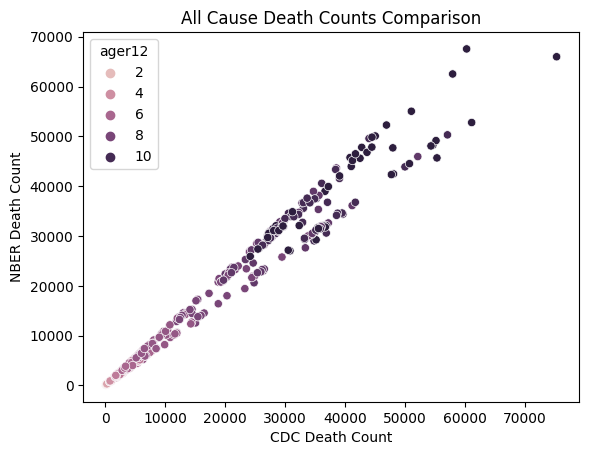

In [29]:
sns.scatterplot(
    y='death_count',
    x='cdc_death_count',
    data=nber_with_cdc,
    hue='ager12'
)
plt.xlabel('CDC Death Count')
plt.ylabel('NBER Death Count')
plt.title('All Cause Death Counts Comparison')
plt.show()

Evidently, they are not one to one. Thus, it is necessary to do some ML to predict NBER death counts, which I trust more than CDC numbers, and which we also have historical data for. 


# Machine Learning

In [31]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


In [33]:
num_cols = ['cdc_death_count', 'monthdth', 'ager12']
cat_cols = ['sex']
response_col = 'death_count'



preproc = ColumnTransformer(
    [('num', 'passthrough', num_cols),
    ('cat', OneHotEncoder(), cat_cols)]
)

In [34]:
reg = RandomForestRegressor()

reg = make_pipeline(preproc, reg)

In [36]:
reg_cv = GridSearchCV(
    reg,
    {'randomforestregressor__n_estimators' : [25, 50, 100, 175],
        'randomforestregressor__max_depth' : [2, 4, 7, 10]
    },
    n_jobs = 4

)

In [37]:
df_train, df_test = train_test_split(nber_with_cdc, test_size = 0.2, random_state=12)

In [38]:
reg_cv.fit(df_train[feature_cols], df_train[response_col])

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['cdc_death_count',
                                                                          'monthdth',
                                                                          'ager12']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['sex'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor())]),
             n_jobs=4,
             param_grid={'randomforestregressor__max_depth': [2, 4, 7, 10],
                         'randomforestregressor__n_estimators': [25, 50, 100,
                                                                 175]})

In [39]:
reg_cv.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__n_estimators': 25}

In [40]:
predicted_nber_counts = reg_cv.predict(df_test)

# Model Evaluation

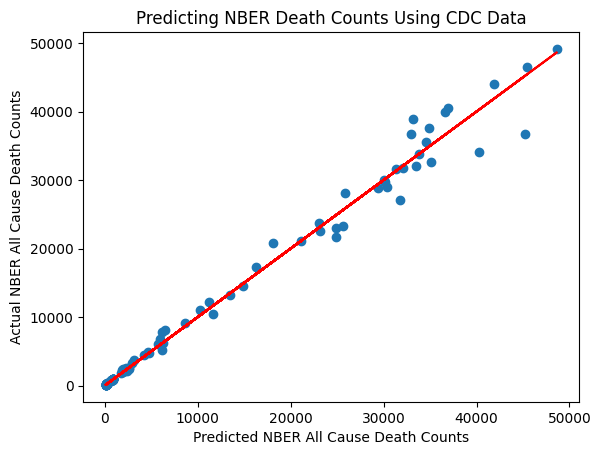

In [41]:
plt.scatter(predicted_nber_counts, df_test[response_col])
plt.plot(predicted_nber_counts, predicted_nber_counts, color='red')
plt.xlabel('Predicted NBER All Cause Death Counts')
plt.ylabel('Actual NBER All Cause Death Counts')
plt.title('Predicting NBER Death Counts Using CDC Data')
plt.show()

In [42]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

In [43]:
for error_func in [r2_score, mean_absolute_error, mean_absolute_percentage_error]:
    error = error_func(df_test[response_col], predicted_nber_counts)
    print(str(error_func).split(' ')[1], error)

r2_score 0.9869845701617301
mean_absolute_error 749.7429462120137
mean_absolute_percentage_error 0.07549729104027202


A 0.986 $R^2$ value is pretty good - while not a perfect approximation, I'm confident that this should get us there until the NBER all cause death counts for 2022 are released


# Saving 

Now, save the model for future use

In [44]:
from allcause.data import path_to_cache

PosixPath('/Users/julianwaugh/old_machine/Documents/Julian/Post_College/coding_projects/allcause/allcause/cache')